In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import xarray as xr
import glob
import os

import py7zr

In [2]:
import zipfile

### Import shared files

In [3]:
covariate_metadata = pd.read_csv('../DATA/Stream_Temp/covariate_metadata.csv', nrows = 100)
covariate_metadata.tail(5)

,COVARIATE,UNITS,SYMBOL,DESCRIPTION,DATA SOURCE (Retrospective),DATA SOURCE (GCM Scenarios)
95,lookup,unitless,not used,"concatination of reach identifier, year, and d...",NaN,NaN
96,tim.date,date,not used,date,NaN,NaN
97,tim.year,year,not used,year,NaN,NaN
98,cov.canopy_rca,percent,not used,proportional canopy cover in the reach contrib...,need to check,NaN
99,cov.canopy_ws,percent,not used,proportional canopy cover in the upstream wate...,need to check,NaN


In [4]:
gcm_metadata = pd.read_csv('../DATA/Stream_Temp/gcm_metadata.csv', nrows = 10)
gcm_metadata

,Global Climate Model short name,GCM long name,Country,Agency,Coupled Model Intercomparison Project version,Emissions scenario,Downscaling method,Hydrology model,Network routing
0,CanESM2,Canadian Earth System Model version 2,Canada,Canadian Centre for Climate Modeling and Analysis,5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
1,CCSM4,Community Climate System Model version 4,USA,"National Center of Atmospheric Research, USA",5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
2,CNRM-CM5,National Center for Meteorological Research Mo...,France,"National Centre of Meteorological Research, Fr...",5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
3,CSIRO-Mk3-6-0,Commonwealth Scientific and Industrial Researc...,Australia,Commonwealth Scientific and Industrial Researc...,5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
4,GDFL-ESM2M,Global Fluid Dynamics Lab's Earth Systems Mode...,USA,"NOAA Geophysical Fluid Dynamics Laboratory, USA",5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
5,HadGEM-CC365,"Hadley Centre Global Environmental Model, Clim...",UK,"Met Office Hadley Center, UK",5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
6,HadGEM2-ES,"Hadley Centre Global Environmental Model, Eart...",UK,"Met Office Hadley Center, UK",5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
7,inmcm4,"Institute of Numerical Mathematics, Coupled Mo...",Russia,"Institute of Numerical Mathematics, Russia",5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
8,IPSL-CM5A-MR,Institut Pierre Simon Laplace Climate Model,France,"Institut Pierre Simon Laplace, France",5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
9,MIROC5,Model for Interdisciplinary Research on Climat...,Japan,Atmosphere and Ocean Research Institute (The U...,5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)


In [5]:
gcms = list(gcm_metadata.iloc[:, 0].values)

shortname_dict = {i+1:gcms[i] for i in list(range(10))}
shortname_dict

{1: 'CanESM2',
 2: 'CCSM4',
 3: 'CNRM-CM5',
 4: 'CSIRO-Mk3-6-0',
 5: 'GDFL-ESM2M',
 6: 'HadGEM-CC365',
 7: 'HadGEM2-ES',
 8: 'inmcm4',
 9: 'IPSL-CM5A-MR',
 10: 'MIROC5'}

In [6]:
# the following use ~ mm/21/yy dates for cutting (i.e. spring starts on March 21) - per Aimee

def assign_season(doy):
    """Assigns a season based on the day of year (doy)."""
    if 1 <= doy <= 79:
        return "winter"
    elif 80 <= doy <= 171:
        return "spring"
    elif 172 <= doy <= 263:
        return "summer"
    elif 264 <= doy <= 356:
        return "fall"
    else:
        return "winter"

In [352]:
def assign_water_year(date):
    """Assigns water year (Oct-Sept) based on date."""
    if date.month >= 10:
        return (date.year +1)
    else: return date.year

In [353]:
# (~4 sec/HUC)
def getSeasonalAnomalies(indf, baseline_period: range, anomaly_periods: list, cols: list):
    cur_huc_anoms = []
    cur_comids = list(indf.COMID.unique())
    for j in cur_comids:
        #Assign water year and season
        cur_df = indf[indf.COMID == j][['date']+ cols]
        cur_ens_med = cur_df.groupby('date').median() # sets index to date
        cur_ens_med['doy'] = cur_ens_med.index.dayofyear
        cur_ens_med['season'] = cur_ens_med['doy'].apply(assign_season)
        for col in cols: cur_ens_med[f'n_{col}'] = cur_ens_med[col].notnull().astype(int)
        
        #Use water year for swe
        cur_swe = cur_ens_med.copy()
        cur_swe['WY'] = cur_swe.index.to_series().apply(assign_water_year)

        # Reclassify end of Sept as summer (pull it into summer of WY[y-1])
        cur_swe.loc[cur_swe.index.month == 9, 'season'] = 'summer'        
        swe_cum = cur_swe[['cov.SWE', 'WY', 'season', 'n_cov.SWE']].groupby(['WY', 'season']).sum()

        
        cur_anomalies = {}
        
        #Determine baseline (median)
        cur_met = cur_ens_med.copy()
        baseline = cur_met[cur_met.index.year.isin(baseline_period)].groupby('season').median()
        for col in cols: 
            baseline[f'n_{col}'] = cur_met[cur_met.index.year.isin(baseline_period)].groupby('season').sum()[f'n_{col}'] # n
            
        swe_df = swe_cum.loc[pd.IndexSlice[baseline_period], :, :]                
        baseline['cov.SWE'] = swe_df.groupby(level=1).median()['cov.SWE']
        baseline['n_cov.SWE'] = swe_df.groupby(level=1).sum()['n_cov.SWE'] # n
        
        
        baseline_trim = pd.concat([baseline[[col, f'n_{col}']] for col in cols], axis = 1)
        
        cur_anomalies[f'{baseline_period[0]}s'] = baseline_trim

        #Calculate anomalies
        for per in anomaly_periods:                
            cur_anoms = cur_ens_med[cur_ens_med.index.year.isin(per)].groupby('season').median().subtract(baseline)
            for col in cols: 
                cur_anoms[f'n_{col}'] = cur_ens_med[cur_ens_med.index.year.isin(per)].groupby('season').sum()[f'n_{col}'] # n

            swe = swe_cum.loc[pd.IndexSlice[per], :, :]                
            cur_anoms['cov.SWE'] = swe.groupby(level=1).median()['cov.SWE'].subtract(baseline['cov.SWE'])
            cur_anoms['n_cov.SWE'] = swe.groupby(level=1).sum()['n_cov.SWE'] # n
            
            cur_anoms_trim = pd.concat([cur_anoms[[col, f'n_{col}']] for col in cols], axis = 1)
            
            cur_anomalies[f'{per[0]}s'] = cur_anoms_trim
        
        cur_seas_anomalies = pd.concat(cur_anomalies, axis = 1)
        cur_huc_anoms.append(cur_seas_anomalies)
    return pd.concat(cur_huc_anoms, keys = cur_comids)
 

In [273]:
temp_dir = '/Volumes/Elements/URycki/temp_data/'

In [274]:
periods = {'2000s': list(range(2000, 2010)),
           '2010s': list(range(2010, 2020)),
           '2020s': list(range(2020, 2030)), 
           '1990s': list(range(1990, 2000)), 
           '2050s': list(range(2050, 2060)), 
           '2080s': list(range(2080, 2090))}

In [275]:
temp_dir_gcms = os.path.join(temp_dir, 'preds_GCM/')
temp_files_gcms = glob.glob(temp_dir_gcms + '*.nc')
print(len(temp_files_gcms))
temp_files_gcms.sort()

1316


In [276]:
temp_dir_retro = os.path.join(temp_dir, 'preds_retro/')
temp_files_retro = glob.glob(temp_dir_retro + 'seasonal_anomalies/' + '*.zip')
print(len(temp_files_retro))
print(temp_files_retro[:3])
temp_files_retro.sort()

1536
['/Volumes/Elements/URycki/temp_data/preds_retro/seasonal_anomalies/1701010107_anoms.zip', '/Volumes/Elements/URycki/temp_data/preds_retro/seasonal_anomalies/1701010108_anoms.zip', '/Volumes/Elements/URycki/temp_data/preds_retro/seasonal_anomalies/1701010106_anoms.zip']


In [277]:
hucs = [f[-13:-3] for f in temp_files_gcms]

## Temperature anomalies

In [20]:
%%time

# Temp anomalies

for cur_huc in hucs[:2]:
    print(cur_huc)

    preds = xr.open_dataset(f'/Volumes/Elements/URycki/temp_data/preds_GCM/{cur_huc}.nc', decode_times=True)
    predsdf = preds.to_dataframe(dim_order = ['COMID', 'GCM', 'date'])
    preds_flat = predsdf.reset_index()

    huc_anoms = getSeasonalAnomalies(preds_flat, baseline_period = periods['2010s'], 
                            anomaly_periods = [periods[key] for key in ('1990s', '2050s', '2080s')], cols = ['COMID', 'date', 'prd.stream_temp'])
    huc_anoms_reindex = huc_anoms.drop(['doy', 'COMID'], level = 1, axis = 1)    
    
    huc_anoms_reindex.reset_index(names = ['COMID', 'season']).to_csv(
        os.path.join(temp_dir_gcms, 'seasonal_anomolies', f'{cur_huc}_anoms.csv'), index = False) #, compression = 'zip')

1701010107


NameError: name 'getSeasonalAnomalies' is not defined

In [26]:
pd.read_csv(os.path.join(temp_dir_gcms, 'seasonal_anomolies', f'{cur_huc}_anoms.csv'), header=[0,1])

,COMID,season,2010s,1990s,2050s,2080s
,Unnamed: 0_level_1,Unnamed: 1_level_1,prd.stream_temp,prd.stream_temp,prd.stream_temp,prd.stream_temp
0,22878623,fall,3.921150,-0.299178,1.096812,2.240112
1,22878623,spring,8.469155,-0.411885,1.633280,2.942516
2,22878623,summer,15.968426,-0.946710,1.242376,2.557516
3,22878623,winter,0.794843,-0.155174,0.526287,1.571385
4,22878625,fall,3.965583,-0.296498,1.080081,2.268231
...,...,...,...,...,...,...
123,22879895,winter,0.323003,0.103842,0.419040,1.216069
124,22879989,fall,2.040540,-0.095128,0.127186,0.459159
125,22879989,spring,3.544079,-0.016492,0.421183,0.953634


In [ ]:
%%time
# Retrospective (input by 6-digit HUC)
for h6 in huc6s:
    print(h6)
    with py7zr.SevenZipFile(os.path.join(temp_dir_retro, f'st_pred_{h6}.7z'), mode='r') as z:
        z.extractall(path = os.path.join(temp_dir_retro, 'tmp'))

    huc10s = [f[-14:-4] for f in glob.glob(os.path.join(temp_dir_retro, 'tmp/*'))]
    huc10s.sort()
    print(len(huc10s), ' huc10s')

    for i in range(len(huc10s)):
        cur_huc = huc10s[i]
        print('\t', f'{cur_huc}')
        try:
            stdf = pd.read_csv(os.path.join(temp_dir_retro, 'tmp/', f'st_pred_{cur_huc}.csv'), parse_dates = ['tim.date'], engine = 'python', on_bad_lines = 'warn')
            stdf.rename({'tim.date': 'date'}, axis = 1, inplace = True)

            # Would make this into an error-handline function for a full dataset
            stdf_sorted = stdf.drop('lookup', axis = 1).sort_values(by = ['COMID', 'date'])
            stdf_sorted['timedelta'] = stdf_sorted['date'].diff()
            stdf_gaps = stdf_sorted[stdf_sorted.timedelta > '1 day']
            if len(stdf_gaps) > 0:
                print('Gaps in ',len(stdf_sorted.COMID.unique()), '/', len(stdf_gaps.COMID.unique()), 'COMIDs')
                print('Gap lengths: ', stdf_gaps.timedelta.unique(), 'ending ', stdf_gaps.date.unique())
            

            huc_anoms_retro = getSeasonalAnomalies(stdf, baseline_period = periods['2010s'], 
                                        anomaly_periods = [periods[key] for key in ('1990s', '2000s')], cols = ['COMID', 'date', 'prd.stream_temp'])
            
            huc_anoms_retro_reindex = huc_anoms_retro.drop(['doy', 'COMID'], level = 1, axis = 1)    
            huc_anoms_retro_reindex.reset_index(names = ['COMID', 'season']).to_csv(
                os.path.join(temp_dir_retro, 'seasonal_anomalies', f'{cur_huc}_anoms.zip'), index = False, compression = 'zip')
    
            os.remove(os.path.join(temp_dir_retro, 'tmp/', f'st_pred_{cur_huc}.csv')) 
        except: pass

In [28]:
%%time
# Retrospective (input by 6-digit HUC)
h6 = 170101
print(h6)
with py7zr.SevenZipFile(os.path.join(temp_dir_retro, f'st_pred_{h6}.7z'), mode='r') as z:
    z.extractall(path = os.path.join(temp_dir_retro, 'tmp'))

huc10s = [f[-14:-4] for f in glob.glob(os.path.join(temp_dir_retro, 'tmp/*'))]
huc10s.sort()
print(len(huc10s), ' huc10s')

170101
248  huc10s
CPU times: user 40.2 s, sys: 638 ms, total: 40.8 s
Wall time: 1min 49s


In [21]:
#for i in range(len(huc10s)):
cur_huc = 1701010107
print('\t', f'{cur_huc}')
stdf = pd.read_csv(os.path.join(temp_dir_retro, 'tmp/', f'st_pred_{cur_huc}.csv'), parse_dates = ['tim.date'], engine = 'python', on_bad_lines = 'warn')
stdf.rename({'tim.date': 'date'}, axis = 1, inplace = True)
# Would make this into an error-handline function for a full dataset
stdf_sorted = stdf.drop('lookup', axis = 1).sort_values(by = ['COMID', 'date'])
stdf_sorted['timedelta'] = stdf_sorted['date'].diff()
stdf_gaps = stdf_sorted[stdf_sorted.timedelta > '1 day']
if len(stdf_gaps) > 0:
    print('Gaps in ',len(stdf_sorted.COMID.unique()), '/', len(stdf_gaps.COMID.unique()), 'COMIDs')
    print('Gap lengths: ', stdf_gaps.timedelta.unique(), 'ending ', stdf_gaps.date.unique())


huc_anoms_retro = getSeasonalAnomalies(stdf, baseline_period = periods['2010s'], 
                            anomaly_periods = [periods[key] for key in ('1990s', '2000s')], cols = ['COMID', 'date', 'prd.stream_temp'])


	 1701010107


NameError: name 'getSeasonalAnomalies' is not defined

<Axes: >

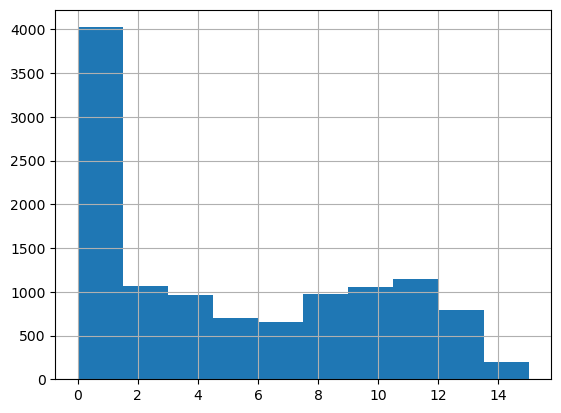

In [57]:
cur_df['prd.stream_temp'].hist()

In [58]:
np.nanmedian(cur_df['prd.stream_temp'])

np.float64(4.048810631632885)

In [ ]:
        cur_ens_med = cur_df.groupby('date').median()
        cur_ens_med['doy'] = cur_ens_med.index.dayofyear
        cur_ens_med['season'] = cur_ens_med['doy'].apply(assign_season)

        cur_anomalies = {}
        baseline = cur_ens_med[cur_ens_med.index.year.isin(baseline_period)].groupby('season').median()
        cur_anomalies[f'{baseline_period[0]}s'] = baseline
        
        for per in anomaly_periods:
            cur_anomalies[f'{per[0]}s'] = cur_ens_med[cur_ens_med.index.year.isin(per)].groupby('season').median().subtract(baseline)
        cur_seas_anomalies = pd.concat(cur_anomalies, axis = 1)
        cur_huc_anoms.append(cur_seas_anomalies)
    return pd.concat(cur_huc_anoms, keys = cur_comids)

In [45]:
stdf_sorted

,COMID,date,cov.antec_air_temp,cov.std_mean_flow,prd.stream_temp,timedelta
0,22878641,1990-01-01,NaN,-1.297848,NaN,NaT
297,22878641,1990-01-02,NaN,-1.297848,NaN,1 days
594,22878641,1990-01-03,NaN,-1.297848,NaN,1 days
891,22878641,1990-01-04,NaN,-1.297848,NaN,1 days
1188,22878641,1990-01-05,NaN,-1.297848,NaN,1 days
...,...,...,...,...,...,...
3470147,947010191,2021-12-27,-7.906900,-4.046519,NaN,1 days
3470444,947010191,2021-12-28,-12.548999,-4.046519,NaN,1 days
3470741,947010191,2021-12-29,-16.687000,-4.046519,NaN,1 days
3471038,947010191,2021-12-30,-18.458766,-4.046519,NaN,1 days


In [121]:
stdf

,lookup,COMID,date,cov.antec_air_temp,cov.std_mean_flow,prd.stream_temp
0,23350315_1990_1,23350315,1990-01-01,NaN,-3.791599,NaN
1,23350395_1990_1,23350395,1990-01-01,NaN,-5.000000,NaN
2,23350429_1990_1,23350429,1990-01-01,NaN,-4.011189,NaN
3,23350431_1990_1,23350431,1990-01-01,NaN,-3.987605,NaN
4,23350433_1990_1,23350433,1990-01-01,NaN,-3.938202,NaN
...,...,...,...,...,...,...
4020667,23352959_2021_365,23352959,2021-12-31,-7.327266,-5.000000,NaN
4020668,23353059_2021_365,23353059,2021-12-31,-8.582966,-5.000000,NaN
4020669,23353063_2021_365,23353063,2021-12-31,-8.955300,-5.000000,NaN
4020670,23353095_2021_365,23353095,2021-12-31,-8.582966,-5.000000,NaN


In [22]:
# Select columns with 'float64' dtype  
float64_cols = list(huc_anoms.select_dtypes(include='float64'))

# The same code again calling the columns
huc_anoms[float64_cols] = huc_anoms[float64_cols].astype('float32')

NameError: name 'huc_anoms' is not defined

## Covariate anomalies

In [278]:
cov_dir_retro = os.path.join(temp_dir, 'preds_retro/')
cov_files_retro = glob.glob(cov_dir_retro + 'seasonal_covariate_anomalies/' + '*.zip')
print(len(cov_files_retro))
print(cov_files_retro[:3])
cov_files_retro.sort()

1542
['/Volumes/Elements/URycki/temp_data/preds_retro/seasonal_covariate_anomalies/1701010107_cov_anoms.zip', '/Volumes/Elements/URycki/temp_data/preds_retro/seasonal_covariate_anomalies/1701010106_cov_anoms.zip', '/Volumes/Elements/URycki/temp_data/preds_retro/seasonal_covariate_anomalies/1701010108_cov_anoms.zip']


In [14]:
%load_ext rpy2.ipython

In [15]:
%%R
install.packages("fst")

R[write to console]: Installing package into ‘/Users/dawn.urycki/Library/R/x86_64/4.3/library’
(as ‘lib’ is unspecified)



--- Please select a CRAN mirror for use in this session ---
Secure CRAN mirrors 

 1: 0-Cloud [https]
 2: Australia (Canberra) [https]
 3: Australia (Melbourne 1) [https]
 4: Australia (Melbourne 2) [https]
 5: Austria (Wien 1) [https]
 6: Belgium (Brussels) [https]
 7: Brazil (PR) [https]
 8: Brazil (SP 1) [https]
 9: Brazil (SP 2) [https]
10: Bulgaria [https]
11: Canada (MB) [https]
12: Canada (ON 1) [https]
13: Canada (ON 2) [https]
14: Chile (Santiago) [https]
15: China (Beijing 2) [https]
16: China (Beijing 3) [https]
17: China (Hefei) [https]
18: China (Hong Kong) [https]
19: China (Jinan) [https]
20: China (Lanzhou) [https]
21: China (Nanjing) [https]
22: China (Shanghai 2) [https]
23: China (Shenzhen) [https]
24: China (Wuhan) [https]
25: Colombia (Cali) [https]
26: Costa Rica [https]
27: Cyprus [https]
28: Czech Republic [https]
29: Denmark [https]
30: East Asia [https]
31: Ecuador (Cuenca) [https]
32: France (Lyon 1) [https]
33: France (Lyon 2) [https]
34: France (Marseille) 

Selection:  70


R[write to console]: trying URL 'https://mirrors.nics.utk.edu/cran/src/contrib/fst_0.9.8.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 274495 bytes (268 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to co

x86_64-apple-darwin13.4.0-clang++ -std=gnu++17 -I"/opt/miniconda3/envs/temp-data-env/lib/R/include" -DNDEBUG  -I'/Users/dawn.urycki/Library/R/x86_64/4.3/library/Rcpp/include' -I'/Users/dawn.urycki/Library/R/x86_64/4.3/library/fstcore/include' -D_FORTIFY_SOURCE=2 -isystem /opt/miniconda3/envs/temp-data-env/include -mmacosx-version-min=10.13 -mmacosx-version-min=10.13 -I/opt/miniconda3/envs/temp-data-env/include    -fPIC  -march=core2 -mtune=haswell -mssse3 -ftree-vectorize -fPIC -fstack-protector-strong -O2 -pipe -stdlib=libc++ -fvisibility-inlines-hidden -fmessage-length=0 -isystem /opt/miniconda3/envs/temp-data-env/include -fdebug-prefix-map=/Users/runner/miniforge3/conda-bld/r-base-split_1728291276454/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/miniconda3/envs/temp-data-env=/usr/local/src/conda-prefix  -c RcppExports.cpp -o RcppExports.o
x86_64-apple-darwin13.4.0-clang++ -std=gnu++17 -I"/opt/miniconda3/envs/temp-data-env/lib/R/include" -DNDEBUG  -I'/Users/dawn.uryc

installing to /Users/dawn.urycki/Library/R/x86_64/4.3/library/00LOCK-fst/00new/fst/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (fst)
R[write to console]: 

R[write to console]: 
R[write to console]: The downloaded source packages are in
	‘/private/var/folders/95/99dy_ns968195cnlvp5xhwqm0000gp/T/RtmpJM0R56/downloaded_packages’
R[write to console]: 
R[write to console]: 



In [24]:
%%R
library(fst)
getwd()

R[write to console]: fst package v0.9.8



[1] "/Users/dawn.urycki/Repos/temp-data"


In [25]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [17]:
colsToUse = ['COMID', 'date', 'cov.air_temp_ws', 'cov.Flow_log', 'cov.SWE_ws']

In [279]:
colsToUse = ['cov.air_temp_ws', 'cov.NWM_flow_log', 'cov.SWE'] #'cov.SWE_ws'] # retro

In [280]:
dataset = 'retro'

In [20]:
%%time
# Future covariates
fail_list = {}

for i in range(len(hucs))[:1]:
    cur_huc = hucs[i]
    print(cur_huc)

    gcm_frames = []
    for cur_gcm in gcms:
        try: gcm_frames.append(ro.r(f"read.fst('/Volumes/Elements/URycki/temp_data/covariates_GCM/{cur_gcm}/huc_{cur_huc}.fst')"))
        except: fail_list['cur_huc'] = cur_gcm  # update this to check if fail_list['cur_huc'] exists; append cur_gcm
        
    if (cur_huc not in fail_list.keys()) & (gcm_frames != []):
        df = pd.concat(gcm_frames)
        df['date'] = pd.to_datetime(df['tim.year'] * 1000 + df['tim.doy'], format='%Y%j')
        print(df.shape)  

        huc_cov_anoms = getSeasonalAnomalies(df, baseline_period = periods['2010s'], 
                            anomaly_periods = [periods[key] for key in ('1990s', '2050s', '2080s')], cols = colsToUse)
        
        huc_cov_anoms_reindex = huc_cov_anoms.drop(['doy', 'COMID'], level = 1, axis = 1)

        #huc_cov_anoms_reindex.reset_index(names = ['COMID', 'season']).to_csv(
            #os.path.join(temp_dir_gcms, 'seasonal_covariate_anomalies', f'{cur_huc}_cov_anoms.zip'), index = False, compression = 'zip')

R[write to console]: fstcore package v0.9.18

R[write to console]: (OpenMP detected, using 16 threads)



1701010107


Exception ignored from cffi callback <function _processevents at 0x1a86b8720>:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/temp-data-env/lib/python3.12/site-packages/rpy2/rinterface_lib/callbacks.py", line 275, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
    
KeyboardInterrupt: 


(16983970, 32)


NameError: name 'getSeasonalAnomalies' is not defined

In [281]:
cur_huc

'1701010107'

In [22]:
gcms

['CanESM2',
 'CCSM4',
 'CNRM-CM5',
 'CSIRO-Mk3-6-0',
 'GDFL-ESM2M',
 'HadGEM-CC365',
 'HadGEM2-ES',
 'inmcm4',
 'IPSL-CM5A-MR',
 'MIROC5']

In [ ]:
cov_dir_retro = os.path.join(temp_dir, 'covariates_retro')

cov_files_retro = glob.glob(cov_dir_retro + '/*.fst')
hucs = [f[-14:-4] for f in cov_files_retro]
hucs.sort()
hucs[:5]

In [354]:
%%time # [~8 hr for full set]
# Retro covariates

for i in range(len(hucs)):
    cur_huc = hucs[i]
    print(cur_huc)

    df = ro.r(f"read.fst('/Volumes/Elements/URycki/temp_data/covariates_retro/huc_{cur_huc}.fst')")

    df['date'] = pd.to_datetime(df['tim.year'] * 1000 + df['tim.doy'], format='%Y%j')
    print(df.shape)  

    huc_cov_anoms = getSeasonalAnomalies(df, baseline_period = periods['2010s'], 
                        anomaly_periods = [periods[key] for key in ('1990s', '2000s')], cols = colsToUse)
    
    huc_cov_anoms.reset_index(names = ['COMID', 'season']).to_csv(
        os.path.join(temp_dir_retro, 'seasonal_covariate_anomalies', f'{cur_huc}_cov_anoms.zip'), index = False, compression = 'zip')


1701010106
(48212, 32)
1701010107
(3579741, 32)
1701010108
(1711526, 32)
1701010109
(2205699, 32)
1701010110
(1675367, 32)
1701010111
(3013250, 32)
1701010112
(3543582, 32)
1701010113
(3350734, 32)
1701010114
(1434307, 32)
1701010115
(2241858, 32)
1701010116
(2314176, 32)
1701010117
(2531130, 32)
1701010201
(3688218, 32)
1701010202
(771392, 32)
1701010203
(2760137, 32)
1701010204
(2567289, 32)
1701010301
(1120929, 32)
1701010302
(879869, 32)
1701010303
(1566890, 32)
1701010304
(1627155, 32)
1701010305
(2024904, 32)
1701010401
(952187, 32)
1701010402
(867816, 32)
1701010403
(1325830, 32)
1701010404
(1807950, 32)
1701010405
(590597, 32)
1701010406
(819604, 32)
1701010407
(3796695, 32)
1701010411
(12053, 32)
1701010502
(349537, 32)
1701010504
(325431, 32)
1701010505
(1241459, 32)
1701010607
(506226, 32)
1701020101
(687021, 32)
1701020102
(5701069, 32)
1701020103
(819604, 32)
1701020104
(2543183, 32)
1701020105
(2085169, 32)
1701020106
(2796296, 32)
1701020107
(2832455, 32)
1701020108
(421

In [347]:
pd.read_csv(os.path.join(temp_dir_retro, 'seasonal_covariate_anomalies', f'{cur_huc}_cov_anoms.zip'), header = [0,1], compression = 'zip')

COMID             season           2010s                    \
   Unnamed: 0_level_1 Unnamed: 1_level_1 cov.air_temp_ws n_cov.air_temp_ws   
0            22878861               fall       -0.928384               930   
1            22878861             spring        4.621116               920   
2            22878861             summer       13.584764               920   
3            22878861             winter       -4.959496               882   
4            22878865               fall        1.111995               930   
5            22878865             spring        7.250537               920   
6            22878865             summer       15.983624               920   
7            22878865             winter       -3.027337               882   
8            22879677               fall        3.946950               930   
9            22879677             spring       10.284000               920   
10           22879677             summer       19.069250               920   
11           22879677             winter       -0.943000               882   
12           22879685               fall        3.946950               930   
13           22879685             spring       10.284000               920   
14           22879685             summer       19.069250               920   
15           22879685             winter       -0.943000               882   

                                                                   1990s  \
   cov.NWM_flow_log n_cov.NWM_flow_log cov.SWE n_cov.SWE cov.air_temp_ws   
0               NaN                  0     0.0         0       -1.448457   
1               NaN                  0     0.0         0       -1.285360   
2               NaN                  0     0.0         0       -1.830384   
3               NaN                  0     0.0         0       -0.568837   
4               NaN                  0     0.0         0       -0.982254   
5               NaN                  0     0.0         0       -1.125068   
6               NaN                  0     0.0         0       -1.473579   
7               NaN                  0     0.0         0       -0.426339   
8               NaN                  0     0.0         0       -1.173950   
9               NaN                  0     0.0         0       -0.571000   
10              NaN                  0     0.0         0       -1.513249   
11              NaN                  0     0.0         0       -0.012500   
12       -11.512925                930     0.0         0       -1.173950   
13        -4.605170                920     0.0         0       -0.571000   
14       -11.512925                920     0.0         0       -1.513249   
15        -4.605170                882     0.0         0       -0.012500   

                                                                            \
   n_cov.air_temp_ws cov.NWM_flow_log n_cov.NWM_flow_log cov.SWE n_cov.SWE   
0                930              NaN                  0     0.0         0   
1                920              NaN                  0     0.0         0   
2                920              NaN                  0     0.0         0   
3                882              NaN                  0     0.0         0   
4                930              NaN                  0     0.0         0   
5                920              NaN                  0     0.0         0   
6                920              NaN                  0     0.0         0   
7                882              NaN                  0     0.0         0   
8                930              NaN                  0     0.0         0   
9                920              NaN                  0     0.0         0   
10               920              NaN                  0     0.0         0   
11               882              NaN                  0     0.0         0   
12               930         0.000000                930     0.0         0   
13               920         0.000000                920     0.0        